Problem Statement:
 You are free to select your dataset, and for each data entry, determine whether it contains any indications of phishing attempts. For instance, analyze if the data includes sensitive requests, urgent prompts, or solicitations.


Author : Jayalakshmi K

In [2]:
pip install emoji -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 4.9 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels
import re
import emoji
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

In [5]:
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mash Games/spam.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
data.shape

(5572, 2)

In [8]:
#check for null values
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [9]:
# find duplicate
data.duplicated().any()

True

In [10]:
#drop duplicates
data.drop_duplicates(inplace=True)

In [11]:
# find duplicate
data.duplicated().any()

False

SPAM vs HAM

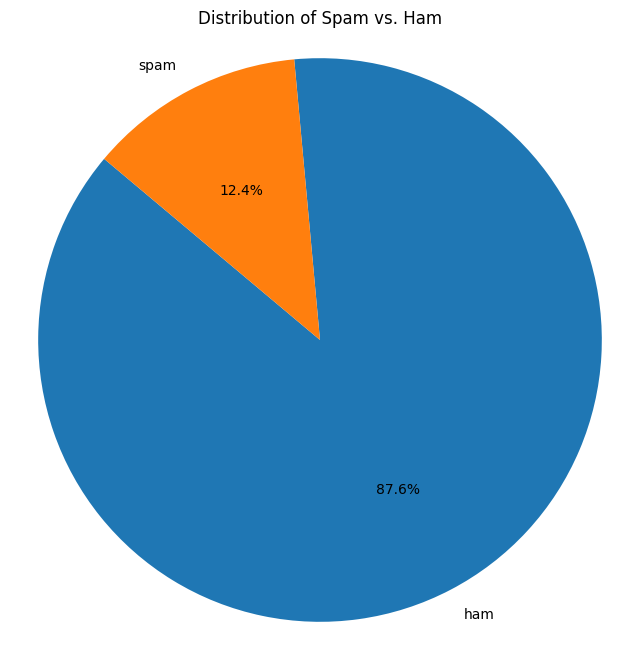

In [12]:
# Calculate the count of each label
category_counts = data['Category'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam vs. Ham')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

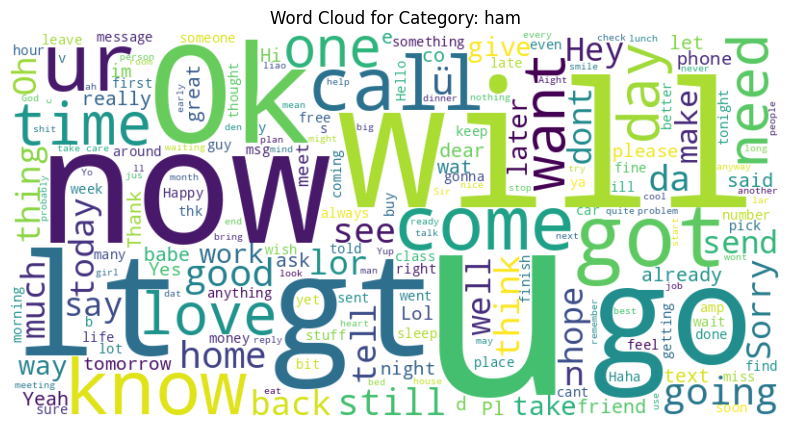

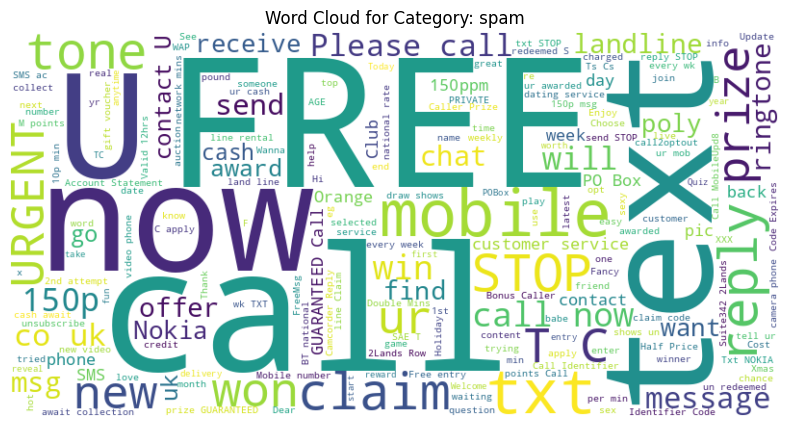

In [13]:
from wordcloud import WordCloud
#Iterate through unique categories
for category in data['Category'].unique():
    # Filter the DataFrame for the current category
    filtered_data = data[data['Category'] == category]

    # Concatenate all text data for the current category
    text = ' '.join(filtered_data['Message'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
# Encode Category column
le = LabelEncoder()
data['Category']=le.fit_transform(data['Category'])
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Preprocessing:
1. Lower casing
2. Remove extra spaces
3. Remove HTML Tags
4. REmove punctuation
6. Remove Special characters
7. Remove Numeric and Non- Alpha numeric
8. Handling Chat words and Stop eords
9. Handling Emojis

In [15]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [16]:
# Lowercase and strip whitespace
data['Message'] = data['Message'].str.lower().str.strip()

# Remove HTML tags, URLs, punctuation, and special characters
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = BeautifulSoup(text, 'html.parser').get_text()  # Remove HTML tags
    text = re.sub(r'\d+', '', text)  # Remove numeric values
    text = text.translate(str.maketrans('', '', punctuation))  # Remove punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

data['Message'] = data['Message'].apply(clean_text)

# Replace chat words with full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

data['Message'] = data['Message'].apply(replace_chat_words)

# Remove stopwords
stop_words = set(stopwords.words('english'))
data['Message'] = data['Message'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Convert emojis to text
data['Message'] = data['Message'].apply(emoji.demojize)

# Stemming
porter_stemmer = PorterStemmer()
data['Message_stemmed'] = data['Message'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))


In [17]:
data.head()

,Category,Message,Message_stemmed
0,0,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,0,ok lar joking wif u oni,ok lar joke wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...,free entri wkli comp win fa cup final tkt st m...
3,0,u dun say early hor u c already say,u dun say earli hor u c alreadi say
4,0,nah dont think goes usf lives around though,nah dont think goe usf live around though


In [18]:
# Intlize CountVectorizer
cv = CountVectorizer()

# Fitting CountVectorizer on X
X = cv.fit_transform(data['Message_stemmed']).toarray()
y = data['Category']

In [19]:
# Train Test Split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [20]:
# Logistic Regression with tuned parameters
lr_model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Multinomial Naive Bayes with tuned parameters
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(X_train, y_train)
mnb_pred = mnb_model.predict(X_test)

# Gaussian Naive Bayes
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)

# Decision Trees with tuned parameters
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Random Forests with tuned parameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the deep learning model
dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
dl_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
dl_pred = (dl_model.predict(X_test) > 0.5).astype("int32")



Epoch 1/10
129/129 [==============================] - 8s 28ms/step - loss: 0.3202 - accuracy: 0.8887 - val_loss: 0.1056 - val_accuracy: 0.9748
Epoch 2/10
129/129 [==============================] - 3s 25ms/step - loss: 0.0744 - accuracy: 0.9825 - val_loss: 0.0634 - val_accuracy: 0.9835
Epoch 3/10
129/129 [==============================] - 3s 24ms/step - loss: 0.0283 - accuracy: 0.9930 - val_loss: 0.0563 - val_accuracy: 0.9826
Epoch 4/10
129/129 [==============================] - 3s 21ms/step - loss: 0.0142 - accuracy: 0.9959 - val_loss: 0.0561 - val_accuracy: 0.9845
Epoch 5/10
129/129 [==============================] - 2s 16ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.0600 - val_accuracy: 0.9845
Epoch 6/10
129/129 [==============================] - 2s 14ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0655 - val_accuracy: 0.9855
Epoch 7/10
129/129 [==============================] - 2s 13ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0712 - val_accuracy: 0.9855

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    # Convert probabilities to binary predictions using the threshold (0.5)
    y_pred = (y_pred > 0.5).astype(int) if (model == dl_model) else y_pred


    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, confusion_mat

# Example usage:
lr_accuracy, lr_precision, lr_recall, lr_conf_matrix = evaluate_model(lr_model, X_test, y_test)
mnb_accuracy, mnb_precision, mnb_recall, mnb_conf_matrix = evaluate_model(mnb_model, X_test, y_test)
gnb_accuracy, gnb_precision, gnb_recall, gnb_conf_matrix = evaluate_model(gnb_model, X_test, y_test)
dt_accuracy, dt_precision, dt_recall, dt_conf_matrix = evaluate_model(dt_model, X_test, y_test)
rf_accuracy, rf_precision, rf_recall, rf_conf_matrix = evaluate_model(rf_model, X_test, y_test)
dl_accuracy, dl_precision, dl_recall, dl_conf_matrix = evaluate_model(dl_model, X_test, y_test)


33/33 [==============================] - 0s 6ms/step


In [49]:
# Print precision, recall, and accuracy for each model
print("Logistic Regression:")
print(f"The accuracy score of Logistic Regression is {lr_accuracy}, The Precision Score is {lr_precision},The Recall Score is {lr_recall}")
print(f"The Confusion matrix is \n{lr_conf_matrix}")
print("\n")

print("Multinomial Naive Bayes:")
print(f"The accuracy score of MultinomialNB is {mnb_accuracy}, The Precision Score is {mnb_precision},The Recall Score is {mnb_recall}")
print(f"The Confusion matrix is \n{mnb_conf_matrix}")
print("\n")

print("Gaussian Naive Bayes:")
print(f"The accuracy score of GaussianNB is {gnb_accuracy}, The Precision Score is {gnb_precision},The Recall Score is {gnb_recall}")
print(f"The Confusion matrix is \n{gnb_conf_matrix}")
print("\n")

print("Decision Trees:")
print(f"The accuracy score of Decision Tree classifier is {dt_accuracy}, The Precision Score is {dt_precision},The Recall Score is {dt_recall}")
print(f"The Confusion matrix is \n{dt_conf_matrix}")
print("\n")

print("Random Forests:")
print(f"The accuracy score of Random Forest classifier is {rf_accuracy}, The Precision Score is {rf_precision},The Recall Score is {rf_recall}")
print(f"The Confusion matrix is \n{rf_conf_matrix}")
print("\n")

print("Deep Learning Simple ANN Model:")
print(f"The accuracy score of Deep Learning Simple ANN Model is {dl_accuracy}, The Precision Score is {dl_precision},The Recall Score is {dl_recall}")
print(f"The Confusion matrix is \n{dl_conf_matrix}")
print("\n")

Logistic Regression:
The accuracy score of Logistic Regression is 0.9718992248062015, The Precision Score is 0.9724528699938659,The Recall Score is 0.9718992248062015
The Confusion matrix is 
[[895   1]
 [ 28 108]]


Multinomial Naive Bayes:
The accuracy score of MultinomialNB is 0.9563953488372093, The Precision Score is 0.9624374427464473,The Recall Score is 0.9563953488372093
The Confusion matrix is 
[[859  37]
 [  8 128]]


Gaussian Naive Bayes:
The accuracy score of GaussianNB is 0.8691860465116279, The Precision Score is 0.9179176426684793,The Recall Score is 0.8691860465116279
The Confusion matrix is 
[[776 120]
 [ 15 121]]


Decision Trees:
The accuracy score of Decision Tree classifier is 0.9525193798449613, The Precision Score is 0.9508188032736695,The Recall Score is 0.9525193798449613
The Confusion matrix is 
[[882  14]
 [ 35 101]]


Random Forests:
The accuracy score of Random Forest classifier is 0.9195736434108527, The Precision Score is 0.9263922211400655,The Recall Sco

In [51]:
# Create a dictionary with evaluation results
evaluation_data = {
    'Model': ['Logistic Regression', 'MultinomialNB', 'GaussianNB', 'Decision Tree', 'Random Forest', "Simple ANN DL"],
    'Accuracy': [lr_accuracy, mnb_accuracy, gnb_accuracy, dt_accuracy,  rf_accuracy,dl_accuracy ],
    'Precision': [lr_precision, mnb_precision, gnb_precision, dt_precision, rf_precision,dl_precision],
   }

# Create a DataFrame
evaluation_df = pd.DataFrame(evaluation_data)

# Sort the DataFrame based on Accuracy and Precision columns in descending order
evaluation_df = evaluation_df.sort_values(by=['Accuracy', 'Precision'], ascending=False)

# Display the sorted DataFrame
print(evaluation_df)

                 Model  Accuracy  Precision
5        Simple ANN DL  0.985465   0.985447
0  Logistic Regression  0.971899   0.972453
1        MultinomialNB  0.956395   0.962437
3        Decision Tree  0.952519   0.950819
4        Random Forest  0.919574   0.926392
2           GaussianNB  0.869186   0.917918


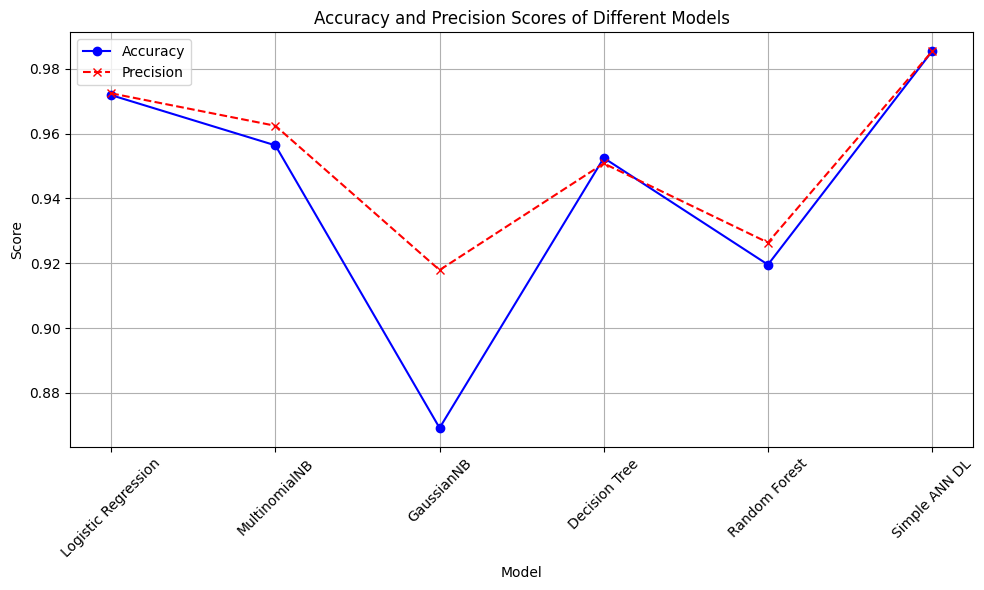

In [54]:
# Define the models and their corresponding accuracy and precision scores
Models = ['Logistic Regression', 'MultinomialNB', 'GaussianNB', 'Decision Tree', 'Random Forest',  "Simple ANN DL"]
Accuracy = [lr_accuracy, mnb_accuracy, gnb_accuracy, dt_accuracy, rf_accuracy, dl_accuracy]
Precision = [lr_precision, mnb_precision, gnb_precision, dt_precision, rf_precision, dl_precision]

# Plotting
plt.figure(figsize=(10, 6))

# Plot accuracy scores
plt.plot(Models, Accuracy, marker='o', linestyle='-', color='b', label='Accuracy')

# Plot precision scores
plt.plot(Models, Precision, marker='x', linestyle='--', color='r', label='Precision')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy and Precision Scores of Different Models')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()